### Formatting data to feed into riserfit
This scripts gives an example of how riser profiles can be extracted from a DEM. The files necessary for this tutorial are located in the Tutorials\Data folder. riserfit provides one big wrapper function to build up riser profiles from DEMs: `rf.construct_z_profiles_from_centerpoints()` should work for most applications. It requires an input DEM file and **a .csv file containing x and y centerpoints at the desired riser locations**. Two examples of such files are supplied in the Data\Risers\Midpoints directory. Running `rf.construct_z_profiles_from_centerpoints()` generates a list of pandas dataframes, one for each profile, and a list of names to identify the dataframes.

The next step is convert this somewhat annoying list of dataframes into a `rf.Riser` instance. This is the main class of the riserfit package. It has a plethora of methods that work on arbitrarily long lists of riser profiles and thus take a lot of `for`-looping overhead away from the user. For ease of use, this `rf.Riser` instance can be saved to a compressed file and loaded directly, avoiding the need to repreatedly extract profiles from the DEM. It also saves all your progress: if you have calculated linear diffusion ages once and save the `rf.Riser` instance, you can load the instance and access the diffusion ages directly!

To make use of this fact, we add some fancy `try`-`except` to our script: If our little script can find the `Riser` instances, there's no need to run `rf.construct_z_profiles_from_centerpoints()`. **Just remember: If you want to change parameters but keep the instance names the same, the script won't actually do anything. You need to delete the old instances first - or rename them!**

In [6]:
# Some imports
import riserfit as rf
import os
import matplotlib.pyplot as plt

In [7]:
# set working directory and parameters
os.chdir(r"C:\\Users\\Lennart\\lennartGit\\personal\\riserfit\\Tutorials")

RASTERNAME = r"\\Data\\DEM\\terraces.tif"
SPACING_DX = 0.5 # in m
N_POINTS = 80 # points projected out from the centerpoint. Total n of points is 2*N_POINTS + 1
SWATH_NUMBER = 2 # number of parallel lines used to average each profile
SWATH_SPACING = 1 # in m

# Relative paths to the .csv files containing your midpoint x, y data
terraces = ["T7", "T3"]
fnames = [f"\\Data\\Risers\\Midpoints\\midpoints_{t}.csv" for t in terraces]

instance_list = []
try: # try to find the riser instances!
    
    for t in terraces:
        
        instance_list.append(
            rf.load_instance(f"\\Data\\Risers\\Instances\\{t}_Riser_instance.gz") # this is the default instance name
        )
    print("Found existing Riser instances!")
    
except: # Do the heavy lifting
    
    for t, fn in zip(terraces, fnames):
    
        # create a list of pandas dataframes, one for each riser profile
        dfs, names = rf.construct_z_profiles_from_centerpoints(
            rasterpath=RASTERNAME, # relative path from current wd
            pointfilepath=fn, # relative path from current wd
            n_points=N_POINTS,
            spacing=SPACING_DX,
            swath_number=SWATH_NUMBER,
            swath_spacing=SWATH_SPACING,
            smooth_first=True, # this is only used to calculate the steepest gradient, it doesn't affect the profiles!
            method="linear", # interpolation method to extract elevation values
            savedir=f"\\Data\\Risers\\Profiles\\{t}\\" # where to save the created csv files
        )
        
        # create Riser instance from the list of dataframes
        riser = rf.initialize_riser_class(
            dfs, names, "x", "y", identifier=t
        )
        # save to .gz file, note that this is now an instance method!
        riser.save_instance(
            r"\\Data\\Risers\\Instances\\"
        )
        instance_list.append(riser)

Found existing Riser instances!


If you execute the cell above two times, it will only display the processing message the first time. The second time it should display the "Found existing Riser instances" message. This setup drastically improves execution times for datasets with many riser profiles and for large DEMs.

### Data formatting inside riserfit
Within riserfit, all data is stored attached to each Riser instance in the form of parameters. Every parameter is a list, every list has the length of `however many profiles there are`. The contents of various lists can be very different: `floats`, `strings`, or more `lists` and/or `np.ndarrays`

[<riserfit.profiles.Riser object at 0x000002780C300A90>, <riserfit.profiles.Riser object at 0x000002780C300EE0>]
['T7-1', 'T7-2', 'T7-3', 'T7-4', 'T7-5', 'T7-6', 'T7-7', 'T7-8', 'T7-9', 'T7-10', 'T7-11', 'T7-12', 'T7-13', 'T7-14', 'T7-15', 'T7-16', 'T7-17', 'T7-18', 'T7-19', 'T7-20', 'T7-21', 'T7-22', 'T7-23', 'T7-24', 'T7-25', 'T7-26', 'T7-27', 'T7-28', 'T7-29']
[]
[]
[-36.5 -36.  -35.5 -35.  -34.5 -34.  -33.5 -33.  -32.5 -32.  -31.5 -31.
 -30.5 -30.  -29.5 -29.  -28.5 -28.  -27.5 -27.  -26.5 -26.  -25.5 -25.
 -24.5 -24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.
 -18.5 -18.  -17.5 -17.  -16.5 -16.  -15.5 -15.  -14.5 -14.  -13.5 -13.
 -12.5 -12.  -11.5 -11.  -10.5 -10.   -9.5  -9.   -8.5  -8.   -7.5  -7.
  -6.5  -6.   -5.5  -5.   -4.5  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.
  -0.5   0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.
   5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.
  11.5  12.   12.5  13.   13.5  14.   14.5  15.   15

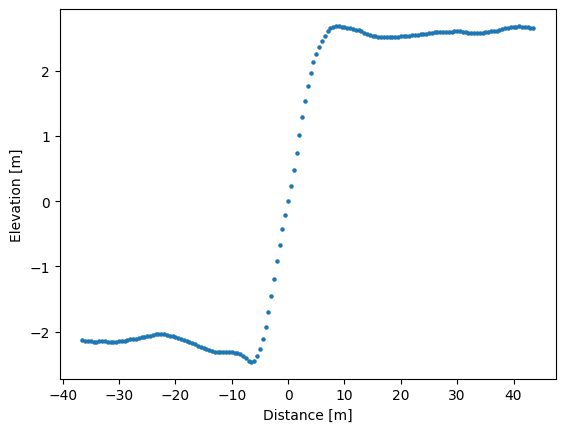

In [8]:
# Has it actually worked? Let's check out the output from the cell above. 
#It is a nest that contains two Riser instances...
print(instance_list)

# For now, let's just look at the first instace. The second is structured in the same way.
riser = instance_list[0]
# It has many properties, such as the profile names, the riser height, diffusion age, etc.
print(riser.name) # Profile name
print(riser.best_a) # "Best-fit" riser height (from midpoint to crest or toe of riser)
print(riser.best_kt) # "Best-fit" linear diffusion age
# You will notice that the last two parameters are just empty lists. That is because we haven't actually
# done the linear diffusion fitting that would calculate both a and kt. The parameters are just pre-allocated.

# The only real data that we have at the moment are x and z data from each profile. In riserfit these are referred to
# as d (the distance, or x) and z (the elevation). 
print(riser.d[0]) # we just look at the first entry of the d-list. It is an entire np.ndarray!
print(riser.z[0]) # this is also a np.ndarray!

# Again, rach entry in any of the parameters of the Riser instance refers to a single profile.
# If we want to plot a profile, we can do it this way:
profile_id = 0
plt.scatter(riser.d[profile_id], riser.z[profile_id], s=5)
plt.xlabel("Distance [m]")
plt.ylabel("Elevation [m]")
plt.show()
# (Not the nicest profile...)